<a href="https://colab.research.google.com/github/zawemi/ZUM/blob/main/Transformer_Tensorflow_Keras_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please fill #TODO lines with Python code

##Imports

####Task 1

Import numpy and tensorflow libraries.
Import softmax from keras.backend.

##Scale-Dot Product Attention

Let's start with implementing Scaled-Dot Product Attention according to the formula:

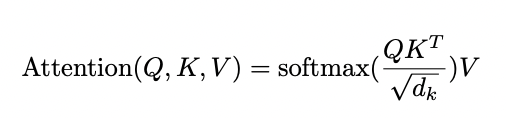

####Task 2

Create function calculating dot product attention (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [ ]:
def dotProductAttention(queries, keys, values, d_k, mask=None):
  # Score the queries against the keys according to the equation
  # Use matmul and sqrt (cast d_k to float32)
  
  scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d_k, tf.float32))
 
  # Apply mask to the attention scores for further use (decoder)
  if mask is not None:
    scores += -1e9 * mask
 
  # Compute the weights by a softmax operation

  #YOUR CODE
 
  # Compute the attention by scoring weights against value vectors
  # Use matmul

  #YOUR CODE

  return attention

In [ ]:
input_seq_length = 5  # Maximum length of the input sequence
d_k = 6  # Dimensionality of the linearly projected (vector) queries and keys
d_v = 4  # Dimensionality of the linearly projected (vector) values
batch_size = 8  # Batch size from the training process
 
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))
 
attention = dotProductAttention(tf.cast(queries, tf.float32), tf.cast(keys, tf.float32), tf.cast(values, tf.float32), d_k)

#Should be [batch_size, input_seq_length, d_k/d_v]
print(f"Queries shape: {queries.shape}")
print(f"Keys shape: {keys.shape}")
print(f"Values shape: {values.shape}")
print(f"Attention shape: {attention.shape}")

Queries shape: (8, 5, 6)
Keys shape: (8, 5, 6)
Values shape: (8, 5, 4)
Attention shape: (8, 5, 4)


##Multi-Head Attention

As "Attention Is All You Need" describes Multihead Attention, let's follow them.

####Task 3

Complete the code below.

In [ ]:
# Implementing the Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        #TODO
        self.heads = ?  # Number of attention heads to use
        self.d_k = ?  # Dimensionality of the linearly projected queries and keys
        self.d_v = ?  # Dimensionality of the linearly projected values
        self.d_model = ?  # Dimensionality of the model
        #TODO
        #Use Dense layer for W_..
        self.W_q = ?  # Learned projection matrix for the queries
        self.W_k = ?  # Learned projection matrix for the keys
        self.W_v = ?  # Learned projection matrix for the values
        self.W_o = ?  # Learned projection matrix for the multi-head output
 
    def reshape_tensor(self, x, heads, flag):
      #tf.reshape: https://www.tensorflow.org/api_docs/python/tf/reshape
      #tf.transpose: https://www.tensorflow.org/api_docs/python/tf/transpose
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))
            x = tf.transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], self.d_k))
        return x
 
    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries. keys and values to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)

        print(f"Q reshaped: {q_reshaped.shape}")
        print(f"K reshaped: {k_reshaped.shape}")
        print(f"V reshaped: {v_reshaped.shape}")
 
        # Compute the (multi-head) attention output using the reshaped queries, keys, values
        #TODO
        #o_reshaped = ?

        print(f"O reshaped: {o_reshaped.shape}")
 
        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        print(f"Output: {output.shape}")
 
        # Final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

####Task 4

Experiment with the values and discover the meaning of each shape of q_reshaped, k_reshaped, v_reshaped, o_reshaped and the output.

In [ ]:
#check your code
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process
 
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))
 
multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)

print(multihead_attention(queries, keys, values).shape)

Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
(64, 5, 512)


##Encoder

Having the attention implemented we can create an encoder as depicted below. It consists od Multi-Head Attention, Normalization Layer, Feed Forward Layer. Remember that Encoder is a stack composed of Encoder Layers.

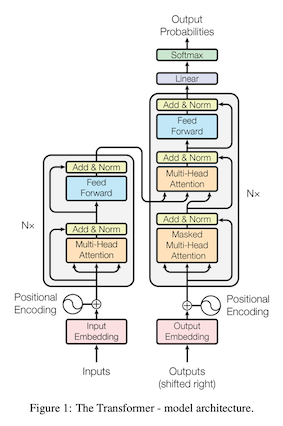

###AddNormalization

####Task 5

Create AddNormalization layer (use LayerNormalization() tf layer)

In [ ]:
# Implementing the Add & Norm Layer
class AddNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        #TODO
        self.layer_norm = ?  # Layer normalization layer
 
    def call(self, x, sublayer_x):
        # Add x and sublayer_x and normalize
        #TODO
        add = ?
        output = ?
        # Apply layer normalization to the sum
        return output

###FeedForward

####Task 6

Implement Feed-Forward Layer using Dense and ReLU layers.

In [ ]:
# Implementing the Feed-Forward Layer
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        #create feedforward layer from one Dense layer of d_ff size, one Dense layer of d_model size and ReLU activation
        #TODO
        self.fully_connected1 = ?
        self.activation = ?
        self.fully_connected2 = ?
 
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        #TODO
        x_fc1 = ?
        x_relu = ?
        x_fc2 = ?

        return x_fc2

###Encoder Layer

In [ ]:
# Implementing the Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()
 
    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
 
        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)
 
        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
 
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
 
        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)
 
        # Followed by another Add & Norm layer
        output = self.add_norm2(addnorm_output, feedforward_output)

        return output

###Positional Embedding

####Task 7
Plot sin() and cos().

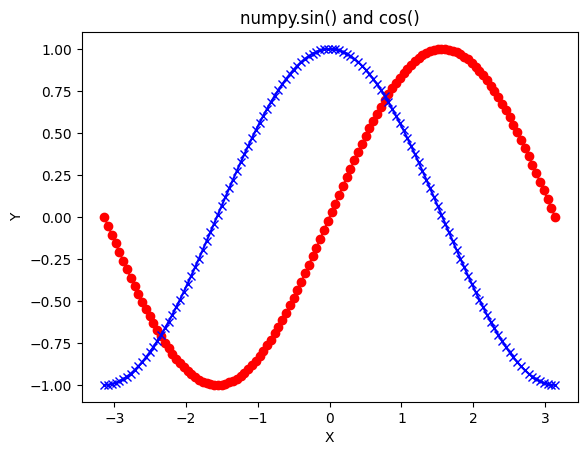

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#visualize sin() and cos()
#np.linspace might be useful https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
#TODO


####Task 8
Create formula for odd indexes embeddings

In [ ]:
class PositionEmbeddingFixedWeights(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=output_dim, weights=[word_embedding_matrix], trainable=False)
        self.position_embedding_layer = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim, weights=[position_embedding_matrix], trainable=False)
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                #create formula for odd indexes
                #TODO
                P[k, 2*i+1] = ?
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

###Encoder

In [ ]:
# Implementing the Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
 
    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
 
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)
 
        return x

In [ ]:
from numpy import random
 
enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
 
input_seq = random.random((batch_size, input_seq_length))
 
encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(encoder(input_seq, None, True).shape)

Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
(64, 5, 512)


##Decoder

###Decoder Layer

####Task 9
Create a decoder layer (refer to encoder layer)

In [ ]:
# Implementing the Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        #TODO
 
    def call(self, x, encoder_output, lookahead_mask):
        # Multi-head attention layer
        #TODO

        return output

###Decoder

In [ ]:
# Implementing the Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
 
    def call(self, output_target, encoder_output, lookahead_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        x = self.dropout(pos_encoding_output, training=training)
 
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x = layer(x, encoder_output, lookahead_mask)
 
        return x

In [ ]:
from numpy import random
 
dec_vocab_size = 20  # Vocabulary size for the decoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of queries and keys
d_v = 64  # Dimensionality of values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the decoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
 
input_seq = random.random((batch_size, input_seq_length))
enc_output = random.random((batch_size, input_seq_length, d_model))
 
decoder = Decoder(dec_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(decoder(input_seq, enc_output, None, True).shape)

Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshaped: (64, 8, 5, 8)
K reshaped: (64, 8, 5, 8)
V reshaped: (64, 8, 5, 8)
O reshaped: (64, 8, 5, 8)
Output: (64, 5, 64)
Q reshap

##Well done. Thank you!

Source:
* https://www.kaggle.com/code/samuelnordmann/transformer-in-tensorflow-from-scratch/notebook
* https://machinelearningmastery.com/how-to-implement-scaled-dot-product-attention-from-scratch-in-tensorflow-and-keras/
* https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/
* https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/
* https://machinelearningmastery.com/implementing-the-transformer-decoder-from-scratch-in-tensorflow-and-keras/
* https://machinelearningmastery.com/joining-the-transformer-encoder-and-decoder-and-masking/
* https://machinelearningmastery.com/training-the-transformer-model/
* https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1
* https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/
* https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=wsINyf1VEQLC
